In [1]:
from utils.all import *

# There's also 'tutorial' and 'preliminary' data
data = load_data('../annotated', batch_num=[5, 6], preprocess=True)

# NOTE: Unlike past data collection, the sentences have been randomized
# among annotators, meaning analysis which averages across sentences or calculates
# inter-annotator agreement may be wrong. Need to fix dataloading to re-sort sentences
# with the same annotators together.

Loading files: ['../annotated/batch_5_anton.json', '../annotated/batch_5_ayush.json', '../annotated/batch_5_kelly.json', '../annotated/batch_5_rachel.json', '../annotated/batch_5_vinayak.json', '../annotated/batch_5_vishnesh.json', '../annotated/batch_6_anton.json', '../annotated/batch_6_ayush.json', '../annotated/batch_6_kelly.json', '../annotated/batch_6_rachel.json', '../annotated/batch_6_vinayak.json', '../annotated/batch_6_vishnesh.json']

Found users: {'vinayak', 'vishnesh', 'ayush', 'kelly', 'anton', 'rachel'}

anton - Batch 5, HIT 38 (ID 37) has 2 deletion edits but 1 annotations. Likely a missing annotation. Skipping edit type...
vinayak - Batch 6, HIT 16 (ID 45) has 1 insertion edits but -1 annotations. Likely a missing annotation. Skipping edit type...
rachel - Batch 5, HIT 21 (ID 65) has 4 deletion edits but 3 annotations. Likely a missing annotation. Skipping edit type...
rachel - Batch 5, HIT 21 (ID 65) has 4 insertion edits but 3 annotations. Likely a missing annotation.

In [2]:
# Print spans with comments
get_comments(data)

ANTON - HIT 3: no change


AYUSH - HIT 105: Annotating this was kind of hard, not sure how to show concatenation with the current taxonomy

ANTON - HIT 108: 



In [3]:
# The systems we looked at
systems = set([x['system'] for x in data])

# Edit types
edit_types = set(data[0]['annotations'].keys())

In [4]:
# Example: Searches for coreference errors
deletions = [process_annotation(k) for k in [i for j in [[x for x in sent['edits'] if x['type'] == 'deletion'] for sent in data] for i in j]]
for d in deletions:
    if d['error_type'] == Error.COREFERENCE:
        print(d)

In [5]:
# Example: Some of the annotations for sentence 0
data[0]['processed_annotations'][:2]

[{'edit_type': 'deletion',
  'id': 0,
  'information_impact': <Information.LESS: 'Generalization'>,
  'type': <Quality.QUALITY: 'No Error'>,
  'family': <Family.CONTENT: 'Content'>,
  'grammar_error': False,
  'error_type': None,
  'rating': 3,
  'size': 0.008310249307479225,
  'reorder_level': None,
  'score': 0.970747553725849},
 {'edit_type': 'deletion',
  'id': 1,
  'information_impact': <Information.LESS: 'Generalization'>,
  'type': <Quality.QUALITY: 'No Error'>,
  'family': <Family.CONTENT: 'Content'>,
  'grammar_error': False,
  'error_type': None,
  'rating': 2,
  'size': 0.030470914127423823,
  'reorder_level': None,
  'score': 0.8085959365626684}]

In [6]:
# Example: Some of the edits for sentence 0
data[0]['edits'][:2]

[{'type': 'deletion',
  'id': 0,
  'original_span': [(92, 95)],
  'simplified_span': None,
  'annotation': ['perfect', 'no', 'no']},
 {'type': 'deletion',
  'id': 1,
  'original_span': [(113, 124)],
  'simplified_span': None,
  'annotation': ['good', 'no', 'no']}]

In [7]:
# Example: Agreement between annotators on edit types
# for edit_type in ['deletion', 'insertion', 'reorder', 'substitution']:
#     print(f'{edit_type} -> {calculate_agreement(data, edit_type, drop_no_spans=True)}')

In [8]:
# TODO: trivial edits on substitutions aren't being processed correctly
# for sent in data:
#     for ann in sent['processed_annotations']:
#         if ann['type'] == Quality.TRIVIAL and ann['rating'] == None:
#             print(sent['id'])
#             print([e for e in sent['edits'] if e['type'] == 'substitution'])
#             print(ann)
#             print(sent['system'])
#             print(sent['system'])
#             print(sent['user'])

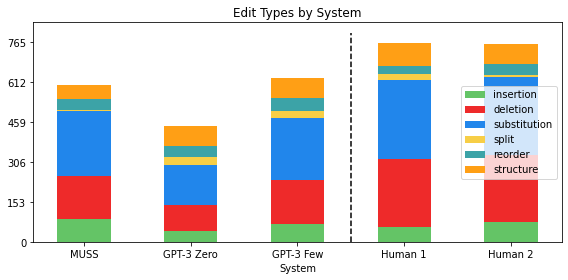

In [9]:
edit_type_by_system(data)

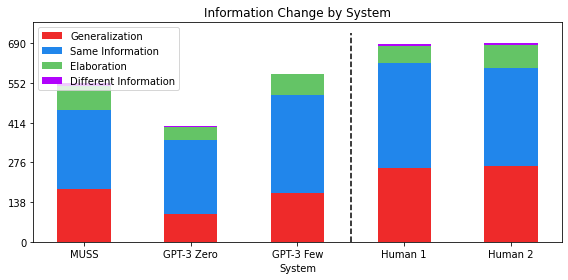

In [10]:
system_by_information_change(data)

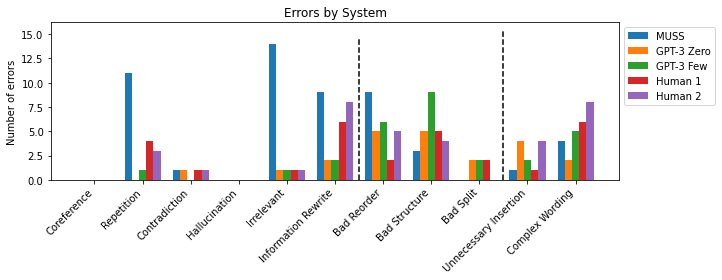

In [11]:
errors_by_system(data)

In [12]:
sankey_combined(data)

In [13]:
# Prints the sentences where annotators identified insertion errors
for error in [Error.REPETITION, Error.CONTRADICTION, Error.HALLUCINATION, Error.IRRELEVANT]:
    print(f'\n{error.value}')
    for sent in data:
        for ann in sent['processed_annotations']:
            if ann['error_type'] == error:
                print(f'{get_sent_info(sent)} \t {system_name_mapping[sent["system"]]}')


Repetition
rachel - Batch 5, HIT 6 (ID 9) 	 Human 1
vinayak - Batch 6, HIT 22 (ID 21) 	 Human 2
vinayak - Batch 6, HIT 17 (ID 46) 	 Human 2
vinayak - Batch 6, HIT 8 (ID 69) 	 MUSS
rachel - Batch 5, HIT 18 (ID 76) 	 MUSS
vishnesh - Batch 5, HIT 39 (ID 76) 	 MUSS
vinayak - Batch 6, HIT 33 (ID 77) 	 Human 1
rachel - Batch 5, HIT 34 (ID 87) 	 MUSS
rachel - Batch 5, HIT 38 (ID 91) 	 MUSS
ayush - Batch 6, HIT 17 (ID 105) 	 Human 2
anton - Batch 6, HIT 29 (ID 127) 	 MUSS
ayush - Batch 6, HIT 28 (ID 127) 	 MUSS
rachel - Batch 6, HIT 21 (ID 127) 	 MUSS
ayush - Batch 6, HIT 29 (ID 128) 	 Human 1
rachel - Batch 6, HIT 23 (ID 128) 	 Human 1
ayush - Batch 6, HIT 4 (ID 137) 	 MUSS
kelly - Batch 6, HIT 9 (ID 137) 	 MUSS
vishnesh - Batch 6, HIT 19 (ID 137) 	 MUSS
rachel - Batch 6, HIT 16 (ID 141) 	 GPT-3 Few

Contradiction
vinayak - Batch 6, HIT 4 (ID 4) 	 MUSS
rachel - Batch 5, HIT 8 (ID 5) 	 GPT-3 Zero
rachel - Batch 5, HIT 26 (ID 79) 	 Human 1
ayush - Batch 6, HIT 7 (ID 95) 	 Human 2

Hallucinatio

In [14]:
# Print the avg. sentence scores for each system
for s in systems:
    print(f'{system_name_mapping[s]} \t {avg([sent["score"] for sent in data if sent["system"] == s])}')

Human 1 	 10.91
MUSS 	 6.14
GPT-3 Zero 	 6.55
Human 2 	 12.49
GPT-3 Few 	 9.72


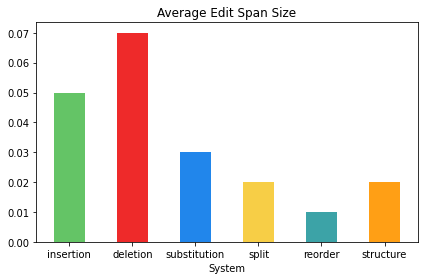

In [15]:
annotations = [x for y in [sent['processed_annotations'] for sent in data] for x in y]
avg_span_size(annotations)

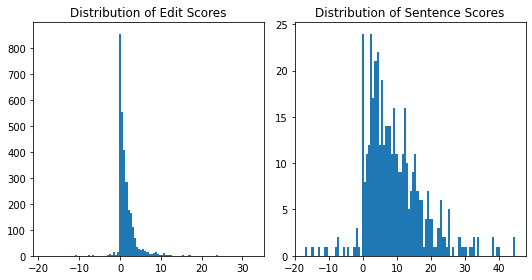

In [16]:
# Show the distribution of edit and sentence scores
score_distribution(data)

In [17]:
# Get the best and worst performing sentences
best, worst = best_performing(data)

Highest Scoring:
vishnesh - Batch 6, HIT 32 (ID 130) - 44.74048122070516
vinayak - Batch 6, HIT 16 (ID 45) - 44.49183097534004
anton - Batch 5, HIT 40 (ID 39) - 40.218971182996725
vinayak - Batch 5, HIT 33 (ID 111) - 39.33684930275075
vinayak - Batch 5, HIT 7 (ID 95) - 38.370866195271674

Lowest scoring:
anton - Batch 5, HIT 29 (ID 28) - -16.917285069615684
ayush - Batch 6, HIT 2 (ID 135) - -14.600727188758242
anton - Batch 5, HIT 25 (ID 24) - -13.068003037735588
anton - Batch 6, HIT 29 (ID 127) - -10.850466165383933
anton - Batch 6, HIT 16 (ID 114) - -10.57465641534539


In [18]:
# Get setences with a score of 0
zeros = zero_scoring_sents(data)

anton - Batch 5, HIT 19 (ID 18)
ayush - Batch 5, HIT 14 (ID 18)
vinayak - Batch 6, HIT 10 (ID 72)


In [19]:
# edit_length(data, systems, simpeval=True)

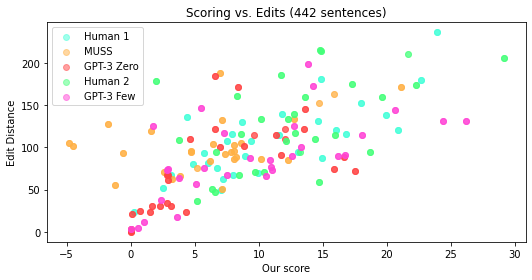

In [20]:
# Averages our scores before plotting
import copy
new_data = copy.deepcopy(data)

for id_ in set([sent['id'] for sent in data]):
    sents = [sent for sent in data if sent['id'] == id_]
    new_score = avg([sent['score'] for sent in sents])
    for i in range(len(new_data)):
        if new_data[i]['id'] == id_:
            new_data[i]['score'] = new_score
            
edit_length(new_data, systems, simpeval=False)

In [21]:
# Get sentences with at least 1 structure change from 1 annotator
ids = set()
for sent in data:
    if 'structure' in [x['type'] for x in sent['edits']]:
        ids.add(sent['id'])
ids = sorted(list(ids))
print(f'Sentences with at least 1 structure change: {len(ids)} / {len(data)}')

Sentences with at least 1 structure change: 113 / 442


anton - Batch 5, HIT 6 (ID 5)

In Marriages and Infidelities, Oates explicitly alludes to novellas and short stories by earlier writers, making use of either their titles or their themes and adapting them in accordance with her artistic intentions.
In "Marriages and Infidelities," Oates uses the titles and themes from earlier novellas and short stories and adapts them to match her own goals.

rachel - Batch 5, HIT 8 (ID 5)

In Marriages and Infidelities, Oates explicitly alludes to novellas and short stories by earlier writers, making use of either their titles or their themes and adapting them in accordance with her artistic intentions.
In "Marriages and Infidelities," Oates uses the titles and themes from earlier novellas and short stories and adapts them to match her own goals.



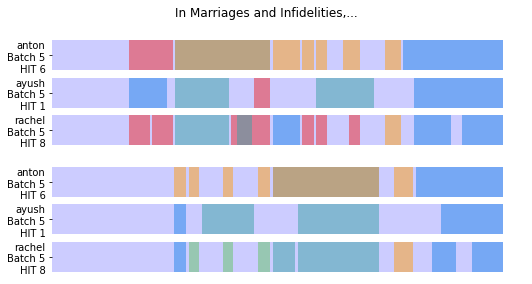

In [22]:
# Display a sentence with a structure change
id_ = 4
sents = [sent for sent in data if sent['id'] == ids[id_]]
print_changes(sents)
draw_agreement(sents)

In [23]:
def error_rate(data):
    # What % of sentences contain at least 1 error?
    error, noterror = 0, 0
    for sent in data:
        for ann in sent['processed_annotations']:
            if ann['type'] == Quality.ERROR:
                error += 1
                break
    print(f"Sentences with at least 1 error: {error/len(data)}")

    error, noterror = 0, 0
    for sent in data:
        for ann in sent['processed_annotations']:
            if ann['type'] == Quality.ERROR and ann['error_type'] != Error.BAD_DELETION:
                error += 1
                break
    print(f"Sentences with at least 1 error excluding bad deletion: {error/len(data)}")

    # What % of edits were errors?
    error, noterror = 0, 0
    for sent in data:
        for ann in sent['processed_annotations']:
            if ann['type'] == Quality.ERROR:
                error += 1
            else:
                noterror += 1
    print(f"Percentage of error edits: {error/(noterror+error)}")

In [24]:
for system in systems:
    print(system)
    error_rate([sent for sent in data if system == sent['system']])
    print()

new-wiki-1/Human 1 Writing
Sentences with at least 1 error: 0.5111111111111111
Sentences with at least 1 error excluding bad deletion: 0.26666666666666666
Percentage of error edits: 0.11773255813953488

new-wiki-1/Muss
Sentences with at least 1 error: 0.8045977011494253
Sentences with at least 1 error excluding bad deletion: 0.5057471264367817
Percentage of error edits: 0.22644927536231885

new-wiki-1/GPT-3-zero-shot
Sentences with at least 1 error: 0.3448275862068966
Sentences with at least 1 error excluding bad deletion: 0.19540229885057472
Percentage of error edits: 0.09975062344139651

new-wiki-1/Human 2 Writing
Sentences with at least 1 error: 0.5454545454545454
Sentences with at least 1 error excluding bad deletion: 0.26136363636363635
Percentage of error edits: 0.12427745664739884

new-wiki-1/GPT-3-few-shot
Sentences with at least 1 error: 0.4111111111111111
Sentences with at least 1 error excluding bad deletion: 0.24444444444444444
Percentage of error edits: 0.09572649572649573

In [25]:
# What % of sentences contain at least 1 error?
error, noterror = 0, 0

subset = [sent for sent in data if 'Human' in sent['system']]
for sent in subset:
    for ann in sent['processed_annotations']:
        if ann['information_impact'] == Information.LESS and ann['type'] == Quality.ERROR and ann['rating'] == 1:
            error += 1
            # print(get_sent_info(sent))
            # print(sent['original'])
            break
print(f"Sentences with at least 1 error: {error/len(data)}")

Sentences with at least 1 error: 0.1425339366515837


In [26]:
# What % content edits are elaboration vs generalization

In [27]:
# Graphs each system with 6 columns each. Each column is a different quality edit. This takes the average rating of each
# edit

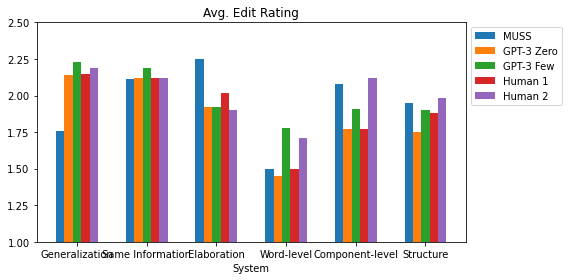

In [28]:
def get_edits_by_type(data, quality_error):
    out = {}
    systems = set([sent['system'] for sent in data])
    for system in systems:
        sents = [sent for sent in data if sent['system'] == system]
        anns = [ann for sent in sents for ann in sent['processed_annotations']]
        avg_score = {}

        quality_edits = [ann for ann in anns if ann['type'] == Quality.QUALITY]
        quality_annotations = {}
        for impact in [i for i in Information if i != Information.DIFFERENT]:
            quality_annotations[impact] = [ann['rating'] for ann in quality_edits if ann['information_impact'] == impact]
        for reorder_level in ReorderLevel:
            quality_annotations[reorder_level] = [ann['rating'] for ann in quality_edits if ann['reorder_level'] == reorder_level]
        quality_annotations[Edit.STRUCTURE] = [ann['rating'] for ann in quality_edits if ann['edit_type'] == Edit.STRUCTURE.value.lower()]
        quality_annotations[Information.SAME] = [ann['rating'] for ann in quality_edits if ann['edit_type'] == Edit.SUBSTITUTION.value.lower() and ann['information_impact'] == Information.SAME]

        
        error_edits = [ann for ann in anns if ann['type'] == Quality.ERROR]
        error_annotations = {}
        for impact in [i for i in Information if i != Information.DIFFERENT]:
            error_annotations[impact] = [ann['rating'] for ann in error_edits if ann['information_impact'] == impact]
        for reorder_level in ReorderLevel:
            error_annotations[reorder_level] = [ann['rating'] for ann in error_edits if ann['reorder_level'] == reorder_level]
        error_annotations[Edit.STRUCTURE] = [ann['rating'] for ann in error_edits if ann['edit_type'] == Edit.STRUCTURE.value.lower()]
        error_annotations[Information.SAME] = [ann['rating'] for ann in error_edits if ann['edit_type'] == Edit.SUBSTITUTION.value.lower() and ann['information_impact'] == Information.SAME]
        
        
        for k in quality_annotations.keys():
            avg_score[k] = avg(quality_annotations[k] + [i for i in error_annotations[k] if i is not None])
            if k != Information.LESS:
                avg_score[k] += 1

        out[system] = avg_score
    return out

out = get_edits_by_type(data, Quality.QUALITY)

# fig, ax = plt.subplots(figsize=(8, 4))
# width = 0.12

# # Get the system labels by preserving the order of systems
# system_labels = [x for x in system_name_mapping if x in out.keys()]
# edit_labels = list(out[list(out.keys())[0]].keys())
# x = np.arange(len(system_labels))

# # Graph the edits
# spacing = [x - 2*width, x - width, x, x + width, x + 2*width, x + 3*width]
# for i, edit_label in enumerate(edit_labels):
#     bottom = [0 for x in range(len(system_labels))]
#     val = [out[label][edit_label] for label in system_labels]
#     ax.bar(spacing[i], val, width, label=edit_label.value, color=color_mapping[edit_label])

# displayed_x_labels = [system_name_mapping[label] for label in system_labels]

# ax.set_title(f'Avg. Edit Rating')
# ax.set_xlabel('System')
# ax.set_xticklabels(['none'] + displayed_x_labels)
# ax.set_yticks(np.arange(0, 3, 0.25))
# ax.legend(bbox_to_anchor=(1, 1), loc="upper left")

# # Set the margins a little higher than the max value
# plt.ylim(1, 2.5)

# plt.show()

fig, ax = plt.subplots(figsize=(8, 4))
width = 0.12

# Get the system labels by preserving the order of systems
system_labels = [x for x in system_name_mapping if x in out.keys()]
edit_labels = list(out[list(out.keys())[0]].keys())
x = np.arange(len(edit_labels))

# Graph the edits
spacing = [x - 2*width, x - width, x, x + width, x + 2*width, x + 3*width]
for i, system in enumerate(system_labels):
    val = [out[system][label] for label in edit_labels]
    ax.bar(spacing[i], val, width, label=system_name_mapping[system]) #, color=color_mapping[edit_label])

displayed_x_labels = [label.value for label in edit_labels]

ax.set_title(f'Avg. Edit Rating')
ax.set_xlabel('System')
ax.set_xticklabels(['none'] + displayed_x_labels)
ax.set_yticks(np.arange(0, 3, 0.25))
ax.legend(bbox_to_anchor=(1, 1), loc="upper left")

# Set the margins a little higher than the max value
plt.ylim(1, 2.5)

plt.show()

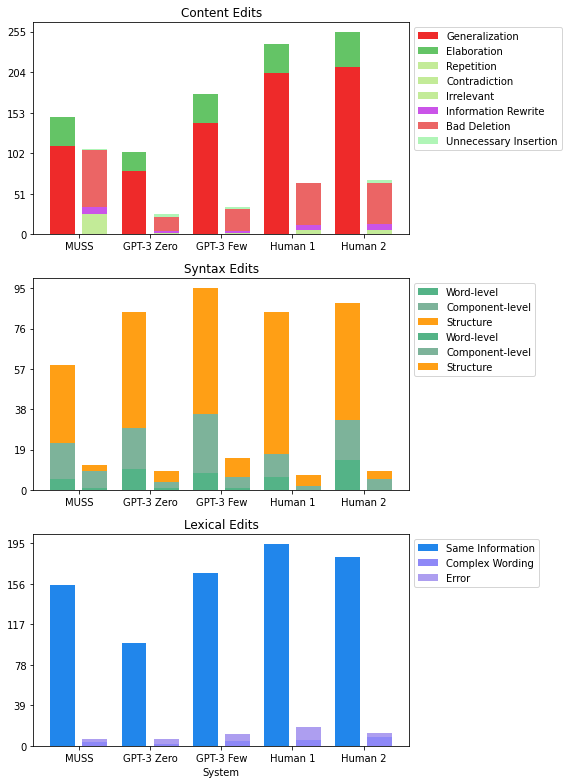

In [29]:
edits_by_family(data)

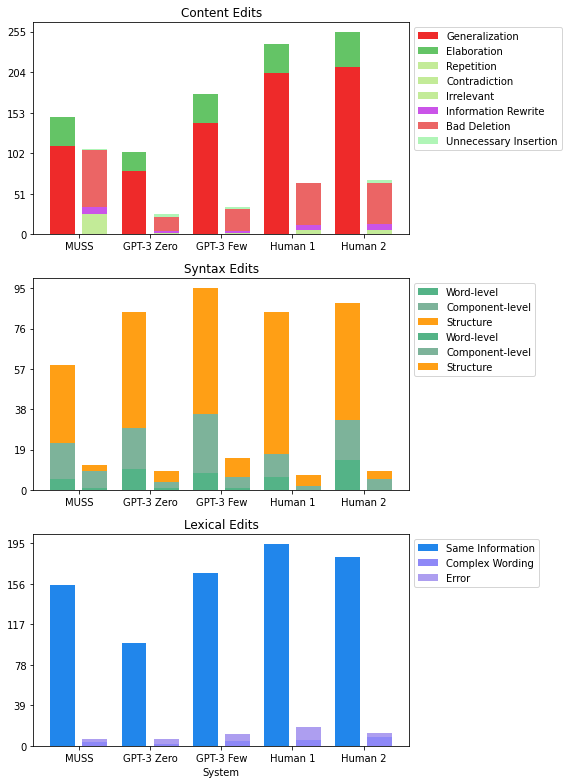

In [30]:
edits_by_family(data, Family.CONTENT)

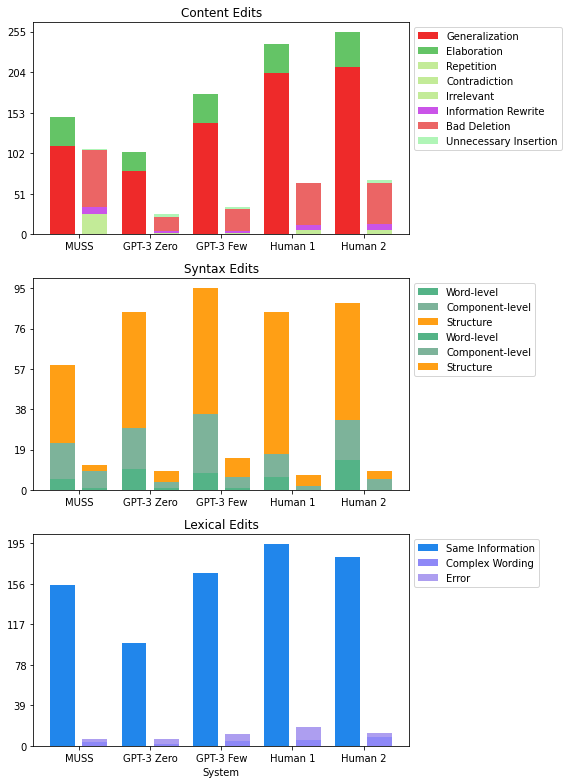

In [31]:
edits_by_family(data, Family.SYNTAX)

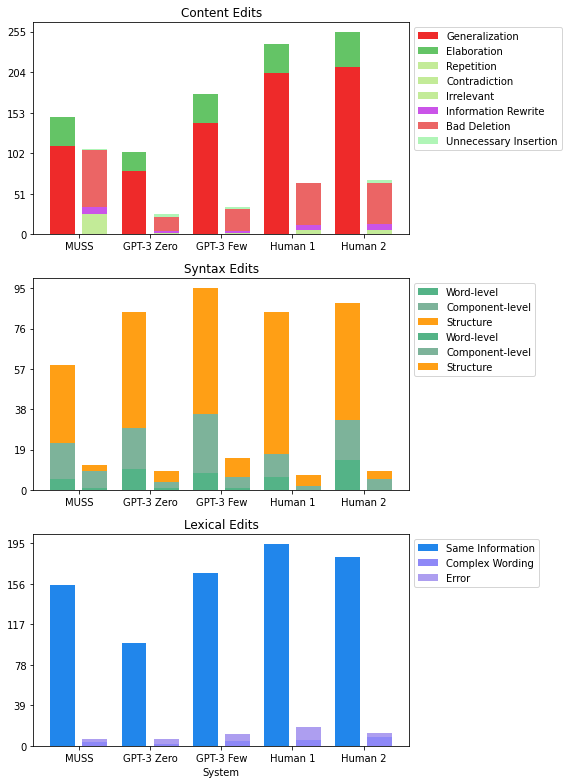

In [32]:
edits_by_family(data, Family.LEXICAL)

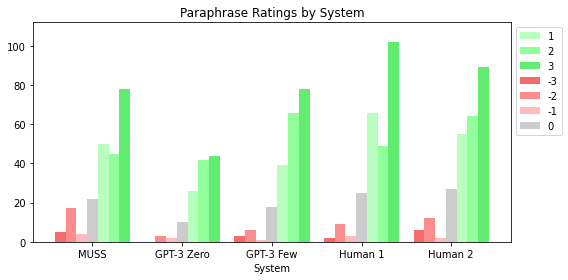

In [33]:
ratings_by_edit_type(data, 'paraphrase')

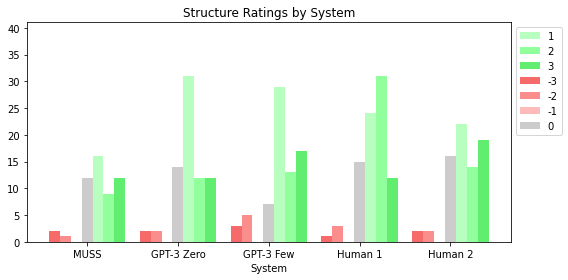

In [34]:
ratings_by_edit_type(data, 'structure')

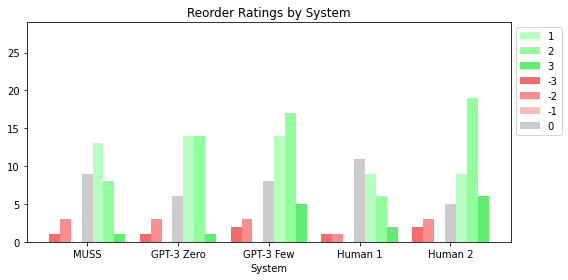

In [35]:
ratings_by_edit_type(data, 'reorder')

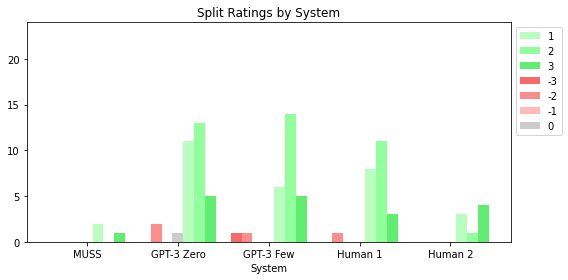

In [36]:
ratings_by_edit_type(data, 'split')

In [37]:
import numpy as np

import matplotlib.pyplot as plt
from matplotlib.patches import Circle, RegularPolygon
from matplotlib.path import Path
from matplotlib.projections.polar import PolarAxes
from matplotlib.projections import register_projection
from matplotlib.spines import Spine
from matplotlib.transforms import Affine2D


def radar_factory(num_vars, frame='circle'):
    """
    Create a radar chart with `num_vars` axes.

    This function creates a RadarAxes projection and registers it.

    Parameters
    ----------
    num_vars : int
        Number of variables for radar chart.
    frame : {'circle', 'polygon'}
        Shape of frame surrounding axes.

    """
    # calculate evenly-spaced axis angles
    theta = np.linspace(0, 2*np.pi, num_vars, endpoint=False)

    class RadarTransform(PolarAxes.PolarTransform):

        def transform_path_non_affine(self, path):
            # Paths with non-unit interpolation steps correspond to gridlines,
            # in which case we force interpolation (to defeat PolarTransform's
            # autoconversion to circular arcs).
            if path._interpolation_steps > 1:
                path = path.interpolated(num_vars)
            return Path(self.transform(path.vertices), path.codes)

    class RadarAxes(PolarAxes):

        name = 'radar'
        PolarTransform = RadarTransform

        def __init__(self, *args, **kwargs):
            super().__init__(*args, **kwargs)
            # rotate plot such that the first axis is at the top
            self.set_theta_zero_location('N')

        def fill(self, *args, closed=True, **kwargs):
            """Override fill so that line is closed by default"""
            return super().fill(closed=closed, *args, **kwargs)

        def plot(self, *args, **kwargs):
            """Override plot so that line is closed by default"""
            lines = super().plot(*args, **kwargs)
            for line in lines:
                self._close_line(line)

        def _close_line(self, line):
            x, y = line.get_data()
            # FIXME: markers at x[0], y[0] get doubled-up
            if x[0] != x[-1]:
                x = np.append(x, x[0])
                y = np.append(y, y[0])
                line.set_data(x, y)

        def set_varlabels(self, labels):
            self.set_thetagrids(np.degrees(theta), labels)

        def _gen_axes_patch(self):
            # The Axes patch must be centered at (0.5, 0.5) and of radius 0.5
            # in axes coordinates.
            if frame == 'circle':
                return Circle((0.5, 0.5), 0.5)
            elif frame == 'polygon':
                return RegularPolygon((0.5, 0.5), num_vars,
                                      radius=.5, edgecolor="k")
            else:
                raise ValueError("Unknown value for 'frame': %s" % frame)

        def _gen_axes_spines(self):
            if frame == 'circle':
                return super()._gen_axes_spines()
            elif frame == 'polygon':
                # spine_type must be 'left'/'right'/'top'/'bottom'/'circle'.
                spine = Spine(axes=self,
                              spine_type='circle',
                              path=Path.unit_regular_polygon(num_vars))
                # unit_regular_polygon gives a polygon of radius 1 centered at
                # (0, 0) but we want a polygon of radius 0.5 centered at (0.5,
                # 0.5) in axes coordinates.
                spine.set_transform(Affine2D().scale(.5).translate(.5, .5)
                                    + self.transAxes)
                return {'polar': spine}
            else:
                raise ValueError("Unknown value for 'frame': %s" % frame)

    register_projection(RadarAxes)
    return theta

colors = ['b', 'r', 'g', 'm', 'y']

In [38]:
# - Average quality edit (or log-size * average) rating for these modification types
#     - Content, Syntax, Lexical
#     - Elaboration, Generalization, Paraphrase, Structure, Reorder, Split
# - Average error edit for Content, Syntax, Lexical i guess?
# - Overlap the annotator’s decision for each system

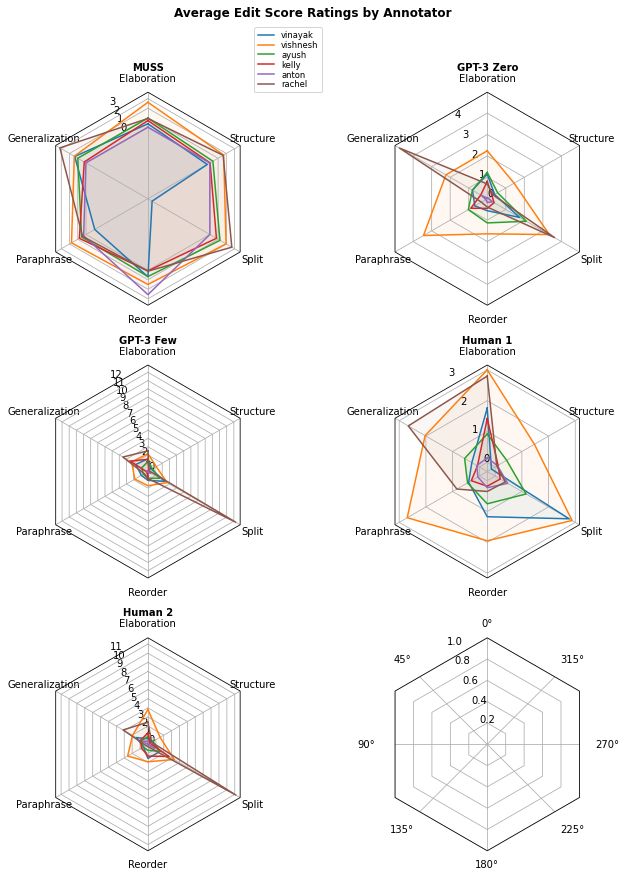

In [39]:
class Tmp(Enum):
    PARAPHRASE = 'Paraphrase'

# We'll start with the average score, which takes into account errors
out = {}
for system in set([x['system'] for x in data]):
    sys = {}

    for annotator in set([x['user'] for x in data]):
        annotator_data = [sent for sent in data if sent['user'] == annotator and sent['system'] == system]
        anns = [i for j  in [sent['processed_annotations'] for sent in annotator_data] for i in j]

        sys[annotator] = {
            Information.MORE: avg([ann['score'] for ann in anns if ann['information_impact'] == Information.MORE]),
            Information.LESS: avg([ann['score'] for ann in anns if ann['information_impact'] == Information.LESS]),
            Tmp.PARAPHRASE: avg([ann['score'] for ann in anns if ann['information_impact'] == Information.SAME and ann['edit_type'] == 'substitution']),
            Edit.REORDER: avg([ann['score'] for ann in anns if ann['edit_type'] == 'reorder']),
            Edit.SPLIT: avg([ann['score'] for ann in anns if ann['edit_type'] == 'split']) / 10,
            Edit.STRUCTURE: avg([ann['score'] for ann in anns if ann['edit_type'] == 'structure']),
        }
    
    out[system] = sys

spokes = list(out[list(out.keys())[0]][list(out[list(out.keys())[0]].keys())[0]].keys())
annotators = list(out[list(out.keys())[0]].keys())

plot_data = [spokes]
for system in [x for x in system_name_mapping if x in out.keys()]:
    sys_data = []
    for annotator in out[system].keys():
        sys_data += [[out[system][annotator][spoke] for spoke in spokes]]
    plot_data += [(system_name_mapping[system], [sys_data])]

# PLOTS

N = len(spokes)
theta = radar_factory(N, frame='polygon')
spoke_labels = [x.value for x in plot_data.pop(0)]

fig, axs = plt.subplots(figsize=(9, 12), nrows=3, ncols=2,
        subplot_kw=dict(projection='radar'))
fig.subplots_adjust(wspace=0.25, hspace=0.20, top=0.85, bottom=0.05)

# Plot the four cases from the example data on separate axes
for ax, (title, case_data) in zip(axs.flat, plot_data):
    ax.set_rgrids([i for i in range(0, 15)])
    ax.set_title(title, weight='bold', size='medium', position=(0.5, 1.1),
                    horizontalalignment='center', verticalalignment='center')
    for d, color in zip(case_data, colors):
        ax.plot(theta, d) # color=color
        ax.fill(theta, d, alpha=0.05, label='_nolegend_') # facecolor=color
    ax.set_varlabels(spoke_labels)

# add legend relative to top-left plot
legend = axs[0, 0].legend(annotators, loc=(1, 1), labelspacing=0.1, fontsize='small')

fig.text(0.5, 1, 'Average Edit Score Ratings by Annotator',
        horizontalalignment='center', color='black', weight='bold', size='large')

plt.show()

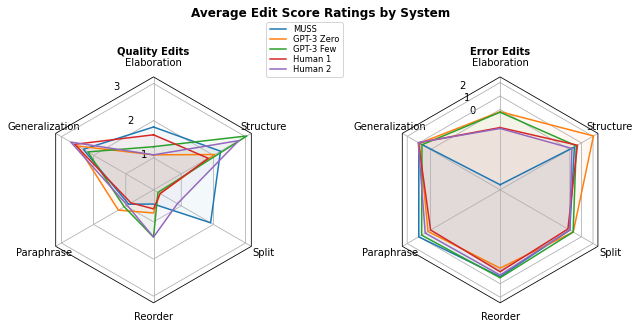

In [40]:
# Separate quality and error charts
out = {}

sys = {}

for system in set([x['system'] for x in data]):
    annotator_data = [sent for sent in data if sent['system'] == system]
    anns = [i for j  in [sent['processed_annotations'] for sent in annotator_data] for i in j if i['type'] == Quality.QUALITY]

    sys[system] = {
        Information.MORE: avg([ann['score'] for ann in anns if ann['information_impact'] == Information.MORE]),
        Information.LESS: avg([ann['score'] for ann in anns if ann['information_impact'] == Information.LESS]),
        Tmp.PARAPHRASE: avg([ann['score'] for ann in anns if ann['information_impact'] == Information.SAME and ann['edit_type'] == 'substitution']),
        Edit.REORDER: avg([ann['score'] for ann in anns if ann['edit_type'] == 'reorder']),
        Edit.SPLIT: avg([ann['score'] for ann in anns if ann['edit_type'] == 'split']) / 5,
        Edit.STRUCTURE: avg([ann['score'] for ann in anns if ann['edit_type'] == 'structure']),
    }

out['quality'] = sys

sys = {}

for system in set([x['system'] for x in data]):
    annotator_data = [sent for sent in data if sent['system'] == system]
    anns = [i for j  in [sent['processed_annotations'] for sent in annotator_data] for i in j if i['type'] == Quality.ERROR]

    sys[system] = {
        Information.MORE: avg([ann['score'] for ann in anns if ann['information_impact'] == Information.MORE]),
        Information.LESS: avg([ann['score'] for ann in anns if ann['information_impact'] == Information.LESS]),
        Tmp.PARAPHRASE: avg([ann['score'] for ann in anns if ann['information_impact'] == Information.SAME and ann['edit_type'] == 'substitution']),
        Edit.REORDER: avg([ann['score'] for ann in anns if ann['edit_type'] == 'reorder']),
        Edit.SPLIT: avg([ann['score'] for ann in anns if ann['edit_type'] == 'split']),
        Edit.STRUCTURE: avg([ann['score'] for ann in anns if ann['edit_type'] == 'structure']),
    }

out['error'] = sys

spokes = list(out[list(out.keys())[0]][list(out[list(out.keys())[0]].keys())[0]].keys())
annotators = [x for x in system_name_mapping if x in list(out[list(out.keys())[0]].keys())]

plot_data = [spokes]

quality_data = []
for system in annotators:
    quality_data += [[out['quality'][system][spoke] for spoke in spokes]]

error_data = []
for system in annotators:
    error_data += [[out['error'][system][spoke] for spoke in spokes]]
    
plot_data += [('Quality Edits', quality_data)]
plot_data += [('Error Edits', error_data)]

# PLOTS

N = len(spokes)
theta = radar_factory(N, frame='polygon')
spoke_labels = [x.value for x in plot_data.pop(0)]

fig, axs = plt.subplots(figsize=(9, 12), nrows=1, ncols=2,
        subplot_kw=dict(projection='radar'))
fig.subplots_adjust(wspace=0.25, hspace=0.20, top=0.85, bottom=0.05)

# Plot the four cases from the example data on separate axes
for ax, (title, case_data) in zip(axs.flat, plot_data):
    ax.set_rgrids([i for i in range(0, 8)])
    ax.set_title(title, weight='bold', size='medium', position=(0.5, 1.1),
                    horizontalalignment='center', verticalalignment='center')
    for d, color in zip(case_data, colors):
        ax.plot(theta, d) # color=color
        ax.fill(theta, d, alpha=0.05, label='_nolegend_') # facecolor=color
    ax.set_varlabels(spoke_labels)

# add legend relative to top-left plot
legend = axs[0].legend([system_name_mapping[x] for x in annotators], loc=(1, 1), labelspacing=0.1, fontsize='small')

fig.text(0.5, 0.7, 'Average Edit Score Ratings by System',
        horizontalalignment='center', color='black', weight='bold', size='large')

plt.show()

Loading files: ['../annotated/batch_1_anton.json', '../annotated/batch_1_ayush.json', '../annotated/batch_1_kelly.json', '../annotated/batch_2_vinayak.json', '../annotated/batch_2_vishnesh.json', '../annotated/batch_3_anton.json', '../annotated/batch_3_ayush.json', '../annotated/batch_3_kelly.json', '../annotated/batch_4_rachel.json', '../annotated/batch_4_vinayak.json', '../annotated/batch_4_vishnesh.json', '../annotated/batch_5_anton.json', '../annotated/batch_5_ayush.json', '../annotated/batch_5_kelly.json', '../annotated/batch_5_rachel.json', '../annotated/batch_5_vinayak.json', '../annotated/batch_5_vishnesh.json', '../annotated/batch_6_anton.json', '../annotated/batch_6_ayush.json', '../annotated/batch_6_kelly.json', '../annotated/batch_6_rachel.json', '../annotated/batch_6_vinayak.json', '../annotated/batch_6_vishnesh.json']

Found users: {'vishnesh', 'vinayak', 'kelly', 'ayush', 'anton', 'rachel'}

anton - Batch 5, HIT 38 (ID 177) has 2 deletion edits but 1 annotations. Likely 

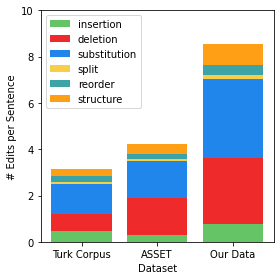

In [41]:
all_data = load_data('../annotated', preprocess=True)
edit_type_by_system(all_data, humans=True, normalized=True)